<a href="https://colab.research.google.com/github/zx20030501/Dive-into-Deep-Learning/blob/main/11.3.%E6%A2%AF%E5%BA%A6%E4%B8%8B%E9%99%8D_gd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 梯度下降
:label:`sec_gd`

尽管*梯度下降*（gradient descent）很少直接用于深度学习，
但了解它是理解下一节随机梯度下降算法的关键。
例如，由于学习率过大，优化问题可能会发散，这种现象早已在梯度下降中出现。
同样地，*预处理*（preconditioning）是梯度下降中的一种常用技术，
还被沿用到更高级的算法中。
让我们从简单的一维梯度下降开始。

## 一维梯度下降

为什么梯度下降算法可以优化目标函数？
一维中的梯度下降给我们很好的启发。
考虑一类连续可微实值函数$f: \mathbb{R} \rightarrow \mathbb{R}$，
利用泰勒展开，我们可以得到

$$f(x + \epsilon) = f(x) + \epsilon f'(x) + \mathcal{O}(\epsilon^2).$$
:eqlabel:`gd-taylor`

即在一阶近似中，$f(x+\epsilon)$可通过$x$处的函数值$f(x)$和一阶导数$f'(x)$得出。
我们可以假设在负梯度方向上移动的$\epsilon$会减少$f$。
为了简单起见，我们选择固定步长$\eta > 0$，然后取$\epsilon = -\eta f'(x)$。
将其代入泰勒展开式我们可以得到

$$f(x - \eta f'(x)) = f(x) - \eta f'^2(x) + \mathcal{O}(\eta^2 f'^2(x)).$$
:eqlabel:`gd-taylor-2`

如果其导数$f'(x) \neq 0$没有消失，我们就能继续展开，这是因为$\eta f'^2(x)>0$。
此外，我们总是可以令$\eta$小到足以使高阶项变得不相关。
因此，

$$f(x - \eta f'(x)) \lessapprox f(x).$$

这意味着，如果我们使用

$$x \leftarrow x - \eta f'(x)$$

来迭代$x$，函数$f(x)$的值可能会下降。
因此，在梯度下降中，我们首先选择初始值$x$和常数$\eta > 0$，
然后使用它们连续迭代$x$，直到停止条件达成。
例如，当梯度$|f'(x)|$的幅度足够小或迭代次数达到某个值时。

下面我们来展示如何实现梯度下降。为了简单起见，我们选用目标函数$f(x)=x^2$。
尽管我们知道$x=0$时$f(x)$能取得最小值，
但我们仍然使用这个简单的函数来观察$x$的变化。


In [ ]:
%matplotlib inline
import numpy as np
import torch
from d2l import torch as d2l

In [ ]:
def f(x):  # 目标函数
    return x ** 2

def f_grad(x):  # 目标函数的梯度(导数)
    return 2 * x

接下来，我们使用$x=10$作为初始值，并假设$\eta=0.2$。
使用梯度下降法迭代$x$共10次，我们可以看到，$x$的值最终将接近最优解。


In [ ]:
def gd(eta, f_grad):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x)
        results.append(float(x))
    print(f'epoch 10, x: {x:f}')
    return results

results = gd(0.2, f_grad)

epoch 10, x: 0.060466


对进行$x$优化的过程可以绘制如下。


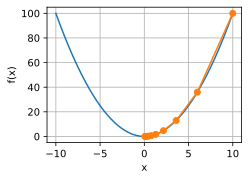

In [ ]:
def show_trace(results, f):
    n = max(abs(min(results)), abs(max(results)))
    f_line = torch.arange(-n, n, 0.01)
    d2l.set_figsize()
    d2l.plot([f_line, results], [[f(x) for x in f_line], [
        f(x) for x in results]], 'x', 'f(x)', fmts=['-', '-o'])

show_trace(results, f)

### 学习率
:label:`subsec_gd-learningrate`

*学习率*（learning rate）决定目标函数能否收敛到局部最小值，以及何时收敛到最小值。
学习率$\eta$可由算法设计者设置。
请注意，如果我们使用的学习率太小，将导致$x$的更新非常缓慢，需要更多的迭代。
例如，考虑同一优化问题中$\eta = 0.05$的进度。
如下所示，尽管经过了10个步骤，我们仍然离最优解很远。


epoch 10, x: 3.486784


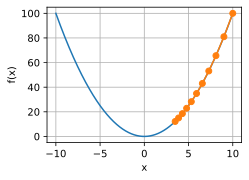

In [ ]:
show_trace(gd(0.05, f_grad), f)

相反，如果我们使用过高的学习率，$\left|\eta f'(x)\right|$对于一阶泰勒展开式可能太大。
也就是说， :eqref:`gd-taylor`中的$\mathcal{O}(\eta^2 f'^2(x))$可能变得显著了。
在这种情况下，$x$的迭代不能保证降低$f(x)$的值。
例如，当学习率为$\eta=1.1$时，$x$超出了最优解$x=0$并逐渐发散。


epoch 10, x: 61.917364


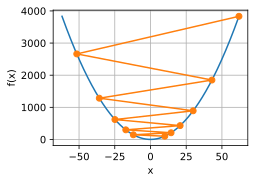

In [ ]:
show_trace(gd(1.1, f_grad), f)

### 局部最小值

为了演示非凸函数的梯度下降，考虑函数$f(x) = x \cdot \cos(cx)$，其中$c$为某常数。
这个函数有无穷多个局部最小值。
根据我们选择的学习率，我们最终可能只会得到许多解的一个。
下面的例子说明了（不切实际的）高学习率如何导致较差的局部最小值。


epoch 10, x: -1.528166


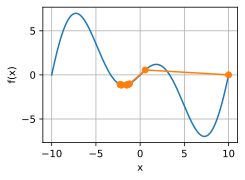

In [ ]:
c = torch.tensor(0.15 * np.pi)

def f(x):  # 目标函数
    return x * torch.cos(c * x)

def f_grad(x):  # 目标函数的梯度
    return torch.cos(c * x) - c * x * torch.sin(c * x)

show_trace(gd(2, f_grad), f)

## 多元梯度下降

现在我们对单变量的情况有了更好的理解，让我们考虑一下$\mathbf{x} = [x_1, x_2, \ldots, x_d]^\top$的情况。
即目标函数$f: \mathbb{R}^d \to \mathbb{R}$将向量映射成标量。
相应地，它的梯度也是多元的，它是一个由$d$个偏导数组成的向量：

$$\nabla f(\mathbf{x}) = \bigg[\frac{\partial f(\mathbf{x})}{\partial x_1}, \frac{\partial f(\mathbf{x})}{\partial x_2}, \ldots, \frac{\partial f(\mathbf{x})}{\partial x_d}\bigg]^\top.$$

梯度中的每个偏导数元素$\partial f(\mathbf{x})/\partial x_i$代表了当输入$x_i$时$f$在$\mathbf{x}$处的变化率。
和先前单变量的情况一样，我们可以对多变量函数使用相应的泰勒近似来思考。
具体来说，

$$f(\mathbf{x} + \boldsymbol{\epsilon}) = f(\mathbf{x}) + \mathbf{\boldsymbol{\epsilon}}^\top \nabla f(\mathbf{x}) + \mathcal{O}(\|\boldsymbol{\epsilon}\|^2).$$
:eqlabel:`gd-multi-taylor`

换句话说，在$\boldsymbol{\epsilon}$的二阶项中，
最陡下降的方向由负梯度$-\nabla f(\mathbf{x})$得出。
选择合适的学习率$\eta > 0$来生成典型的梯度下降算法：

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f(\mathbf{x}).$$

这个算法在实践中的表现如何呢？
我们构造一个目标函数$f(\mathbf{x})=x_1^2+2x_2^2$，
并有二维向量$\mathbf{x} = [x_1, x_2]^\top$作为输入，
标量作为输出。
梯度由$\nabla f(\mathbf{x}) = [2x_1, 4x_2]^\top$给出。
我们将从初始位置$[-5, -2]$通过梯度下降观察$\mathbf{x}$的轨迹。

我们还需要两个辅助函数：
第一个是update函数，并将其应用于初始值20次；
第二个函数会显示$\mathbf{x}$的轨迹。


In [ ]:
def train_2d(trainer, steps=20, f_grad=None):  #@save
    """用定制的训练机优化2D目标函数"""
    # s1和s2是稍后将使用的内部状态变量
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results

In [ ]:
def show_trace_2d(f, results):  #@save
    """显示优化过程中2D变量的轨迹"""
    d2l.set_figsize()
    d2l.plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = torch.meshgrid(torch.arange(-5.5, 1.0, 0.1),
                          torch.arange(-3.0, 1.0, 0.1), indexing='ij')
    d2l.plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')

接下来，我们观察学习率$\eta = 0.1$时优化变量$\mathbf{x}$的轨迹。
可以看到，经过20步之后，$\mathbf{x}$的值接近其位于$[0, 0]$的最小值。
虽然进展相当顺利，但相当缓慢。


epoch 20, x1: -0.057646, x2: -0.000073


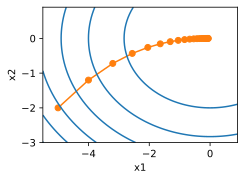

In [ ]:
def f_2d(x1, x2):  # 目标函数
    return x1 ** 2 + 2 * x2 ** 2

def f_2d_grad(x1, x2):  # 目标函数的梯度
    return (2 * x1, 4 * x2)

def gd_2d(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    return (x1 - eta * g1, x2 - eta * g2, 0, 0)

eta = 0.1
show_trace_2d(f_2d, train_2d(gd_2d, f_grad=f_2d_grad))

## 自适应方法

正如我们在 :numref:`subsec_gd-learningrate`中所看到的，选择“恰到好处”的学习率$\eta$是很棘手的。
如果我们把它选得太小，就没有什么进展；如果太大，得到的解就会振荡，甚至可能发散。
如果我们可以自动确定$\eta$，或者完全不必选择学习率，会怎么样？
除了考虑目标函数的值和梯度、还考虑它的曲率的二阶方法可以帮我们解决这个问题。
虽然由于计算代价的原因，这些方法不能直接应用于深度学习，但它们为如何设计高级优化算法提供了有用的思维直觉，这些算法可以模拟下面概述的算法的许多理想特性。

### 牛顿法

回顾一些函数$f: \mathbb{R}^d \rightarrow \mathbb{R}$的泰勒展开式，事实上我们可以把它写成

$$f(\mathbf{x} + \boldsymbol{\epsilon}) = f(\mathbf{x}) + \boldsymbol{\epsilon}^\top \nabla f(\mathbf{x}) + \frac{1}{2} \boldsymbol{\epsilon}^\top \nabla^2 f(\mathbf{x}) \boldsymbol{\epsilon} + \mathcal{O}(\|\boldsymbol{\epsilon}\|^3).$$
:eqlabel:`gd-hot-taylor`

为了避免繁琐的符号，我们将$\mathbf{H} \stackrel{\mathrm{def}}{=} \nabla^2 f(\mathbf{x})$定义为$f$的Hessian，是$d \times d$矩阵。
当$d$的值很小且问题很简单时，$\mathbf{H}$很容易计算。
但是对于深度神经网络而言，考虑到$\mathbf{H}$可能非常大，
$\mathcal{O}(d^2)$个条目的存储代价会很高，
此外通过反向传播进行计算可能雪上加霜。
然而，我们姑且先忽略这些考量，看看会得到什么算法。

毕竟，$f$的最小值满足$\nabla f = 0$。
遵循 :numref:`sec_calculus`中的微积分规则，
通过取$\boldsymbol{\epsilon}$对 :eqref:`gd-hot-taylor`的导数，
再忽略不重要的高阶项，我们便得到

$$\nabla f(\mathbf{x}) + \mathbf{H} \boldsymbol{\epsilon} = 0 \text{ and hence }
\boldsymbol{\epsilon} = -\mathbf{H}^{-1} \nabla f(\mathbf{x}).$$

也就是说，作为优化问题的一部分，我们需要将Hessian矩阵$\mathbf{H}$求逆。

举一个简单的例子，对于$f(x) = \frac{1}{2} x^2$，我们有$\nabla f(x) = x$和$\mathbf{H} = 1$。
因此，对于任何$x$，我们可以获得$\epsilon = -x$。
换言之，单单一步就足以完美地收敛，而无须任何调整。
我们在这里比较幸运：泰勒展开式是确切的，因为$f(x+\epsilon)= \frac{1}{2} x^2 + \epsilon x + \frac{1}{2} \epsilon^2$。

让我们看看其他问题。
给定一个凸双曲余弦函数$c$，其中$c$为某些常数，
我们可以看到经过几次迭代后，得到了$x=0$处的全局最小值。


epoch 10, x: tensor(0.)


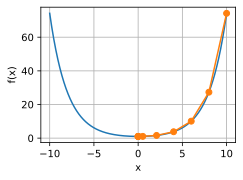

In [ ]:
c = torch.tensor(0.5)

def f(x):  # O目标函数
    return torch.cosh(c * x)

def f_grad(x):  # 目标函数的梯度
    return c * torch.sinh(c * x)

def f_hess(x):  # 目标函数的Hessian
    return c**2 * torch.cosh(c * x)

def newton(eta=1):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x) / f_hess(x)
        results.append(float(x))
    print('epoch 10, x:', x)
    return results

show_trace(newton(), f)

现在让我们考虑一个非凸函数，比如$f(x) = x \cos(c x)$，$c$为某些常数。
请注意在牛顿法中，我们最终将除以Hessian。
这意味着如果二阶导数是负的，$f$的值可能会趋于增加。
这是这个算法的致命缺陷！
让我们看看实践中会发生什么。


epoch 10, x: tensor(26.8341)


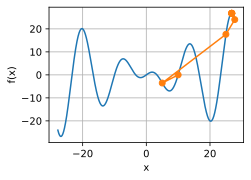

In [ ]:
c = torch.tensor(0.15 * np.pi)

def f(x):  # 目标函数
    return x * torch.cos(c * x)

def f_grad(x):  # 目标函数的梯度
    return torch.cos(c * x) - c * x * torch.sin(c * x)

def f_hess(x):  # 目标函数的Hessian
    return - 2 * c * torch.sin(c * x) - x * c**2 * torch.cos(c * x)

show_trace(newton(), f)

这发生了惊人的错误。我们怎样才能修正它？
一种方法是用取Hessian的绝对值来修正，另一个策略是重新引入学习率。
这似乎违背了初衷，但不完全是——拥有二阶信息可以使我们在曲率较大时保持谨慎，而在目标函数较平坦时则采用较大的学习率。
让我们看看在学习率稍小的情况下它是如何生效的，比如$\eta = 0.5$。
如我们所见，我们有了一个相当高效的算法。


epoch 10, x: tensor(7.2699)


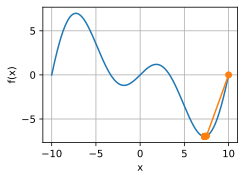

In [ ]:
show_trace(newton(0.5), f)

### 收敛性分析

在此，我们以部分目标凸函数$f$为例，分析它们的牛顿法收敛速度。
这些目标凸函数三次可微，而且二阶导数不为零，即$f'' > 0$。
由于多变量情况下的证明是对以下一维参数情况证明的直接拓展，对我们理解这个问题不能提供更多帮助，因此我们省略了多变量情况的证明。

用$x^{(k)}$表示$x$在第$k^\mathrm{th}$次迭代时的值，
令$e^{(k)} \stackrel{\mathrm{def}}{=} x^{(k)} - x^*$表示$k^\mathrm{th}$迭代时与最优性的距离。
通过泰勒展开，我们得到条件$f'(x^*) = 0$可以写成

$$0 = f'(x^{(k)} - e^{(k)}) = f'(x^{(k)}) - e^{(k)} f''(x^{(k)}) + \frac{1}{2} (e^{(k)})^2 f'''(\xi^{(k)}),$$

这对某些$\xi^{(k)} \in [x^{(k)} - e^{(k)}, x^{(k)}]$成立。
将上述展开除以$f''(x^{(k)})$得到

$$e^{(k)} - \frac{f'(x^{(k)})}{f''(x^{(k)})} = \frac{1}{2} (e^{(k)})^2 \frac{f'''(\xi^{(k)})}{f''(x^{(k)})}.$$

回想之前的方程$x^{(k+1)} = x^{(k)} - f'(x^{(k)}) / f''(x^{(k)})$。
代入这个更新方程，取两边的绝对值，我们得到

$$\left|e^{(k+1)}\right| = \frac{1}{2}(e^{(k)})^2 \frac{\left|f'''(\xi^{(k)})\right|}{f''(x^{(k)})}.$$

因此，每当我们处于有界区域$\left|f'''(\xi^{(k)})\right| / (2f''(x^{(k)})) \leq c$，
我们就有一个二次递减误差

$$\left|e^{(k+1)}\right| \leq c (e^{(k)})^2.$$

另一方面，优化研究人员称之为“线性”收敛，而将$\left|e^{(k+1)}\right| \leq \alpha \left|e^{(k)}\right|$这样的条件称为“恒定”收敛速度。
请注意，我们无法估计整体收敛的速度，但是一旦我们接近极小值，收敛将变得非常快。
另外，这种分析要求$f$在高阶导数上表现良好，即确保$f$在如何变化它的值方面没有任何“超常”的特性。

### 预处理

计算和存储完整的Hessian非常昂贵，而改善这个问题的一种方法是“预处理”。
它回避了计算整个Hessian，而只计算“对角线”项，即如下的算法更新：

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \mathrm{diag}(\mathbf{H})^{-1} \nabla f(\mathbf{x}).$$

虽然这不如完整的牛顿法精确，但它仍然比不使用要好得多。
为什么预处理有效呢？
假设一个变量以毫米表示高度，另一个变量以公里表示高度的情况。
假设这两种自然尺度都以米为单位，那么我们的参数化就出现了严重的不匹配。
幸运的是，使用预处理可以消除这种情况。
梯度下降的有效预处理相当于为每个变量选择不同的学习率（矢量$\mathbf{x}$的坐标）。
我们将在后面一节看到，预处理推动了随机梯度下降优化算法的一些创新。

### 梯度下降和线搜索

梯度下降的一个关键问题是我们可能会超过目标或进展不足，
解决这一问题的简单方法是结合使用线搜索和梯度下降。
也就是说，我们使用$\nabla f(\mathbf{x})$给出的方向，
然后进行二分搜索，以确定哪个学习率$\eta$使$f(\mathbf{x} - \eta \nabla f(\mathbf{x}))$取最小值。

有关分析和证明，此算法收敛迅速（请参见 :cite:`Boyd.Vandenberghe.2004`）。
然而，对深度学习而言，这不太可行。
因为线搜索的每一步都需要评估整个数据集上的目标函数，实现它的方式太昂贵了。

## 小结

* 学习率的大小很重要：学习率太大会使模型发散，学习率太小会没有进展。
* 梯度下降会可能陷入局部极小值，而得不到全局最小值。
* 在高维模型中，调整学习率是很复杂的。
* 预处理有助于调节比例。
* 牛顿法在凸问题中一旦开始正常工作，速度就会快得多。
* 对于非凸问题，不要不作任何调整就使用牛顿法。

## 练习

1. 用不同的学习率和目标函数进行梯度下降实验。
1. 在区间$[a, b]$中实现线搜索以最小化凸函数。
    1. 是否需要导数来进行二分搜索，即决定选择$[a, (a+b)/2]$还是$[(a+b)/2, b]$。
    1. 算法的收敛速度有多快？
    1. 实现该算法，并将其应用于求$\log (\exp(x) + \exp(-2x -3))$的最小值。
1. 设计一个定义在$\mathbb{R}^2$上的目标函数，它的梯度下降非常缓慢。提示：不同坐标的缩放方式不同。
1. 使用预处理实现牛顿方法的轻量版本。
    1. 使用对角Hessian作为预条件子。
    1. 使用它的绝对值，而不是实际值（可能有符号）。
    1. 将此应用于上述问题。
1. 将上述算法应用于多个目标函数（凸或非凸）。如果把坐标旋转$45$度会怎么样？


# 附录 个人再理解

# 什么是梯度下降（gradient descent）法，具体如何实现，举一个3*3的例子

### 一、梯度下降法是什么？

梯度下降（*Gradient Descent*）是一种 **通用的、基于一阶导数** 的数值优化方法，用来在参数空间中寻找可微目标函数
$J(\boldsymbol{\theta})$ 的 **最小值**。
核心思想：

> **沿着函数在当前位置的梯度（最陡上升方向）的反方向** 迈出一步，就能让目标函数值最快速地下滑。

---

### 二、标准梯度下降算法流程

| 步骤       | 说明                                                                             |
| -------- | ------------------------------------------------------------------------------ |
| ①  初始化参数 | 选择初始参数向量 $\boldsymbol{\theta}^{(0)}$，可随机或零向量                                   |
| ②  计算梯度  | 令 $\mathbf{g}^{(t)}=\nabla_{\theta} J(\boldsymbol{\theta}^{(t)})$              |
| ③  参数更新  | $\boldsymbol{\theta}^{(t+1)}=\boldsymbol{\theta}^{(t)}-\eta\,\mathbf{g}^{(t)}$ |
| ④  判断收敛  | 若 $\|\mathbf{g}^{(t)}\|$ 或 $J$ 下降幅度已足够小，则停止；否则回到②                              |

* **学习率 $\eta$**（step size）控制每一步的移动距离；过大易震荡甚至发散，过小则收敛慢。
* **变体**

  * **批量梯度下降 (BGD)**：每次用全部样本计算梯度，收敛稳定但对大数据慢。
  * **随机梯度下降 (SGD)**：一次只用一个样本；更新频繁、噪声大但可跳出局部最小。
  * **小批量梯度下降 (Mini-batch GD)**：一次用几十到几百个样本，兼顾速度与稳定性。
  * **自适应学习率**：AdaGrad、RMSProp、Adam 等在更新公式中动态调整 $\eta$。

---

### 三、3 × 3 实例：最小化二次损失

> **目标函数**
> $J(\mathbf{w})=\dfrac12\lVert A\mathbf{w}-\mathbf{b}\rVert_2^{2}$

其中

$$
A=
\begin{bmatrix}
1 & 2 & 3\\
4 & 5 & 6\\
7 & 8 & 9
\end{bmatrix},
\qquad
\mathbf{b}=
\begin{bmatrix}
1\\2\\3
\end{bmatrix},
\qquad
\mathbf{w}=
\begin{bmatrix}
w_1\\w_2\\w_3
\end{bmatrix}
$$

#### 1. 梯度公式

对于该二次型，梯度 **可一次写成矩阵形式**

$$
\nabla_{\mathbf{w}}J(\mathbf{w}) = A^{\mathsf T}(A\mathbf{w}-\mathbf{b})
$$

#### 2. 手算首两次迭代（学习率 $\eta=0.01$）

| 迭代 $t$  | $\mathbf{w}^{(t)}$           | 误差 $\mathbf{e}^{(t)}=A\mathbf{w}^{(t)}-\mathbf{b}$                                                     | 梯度 $\mathbf{g}^{(t)}=A^\mathsf T\mathbf{e}^{(t)}$           | 更新                                                                                        |
| ------- | ---------------------------- | ------------------------------------------------------------------------------------------------------ | ----------------------------------------------------------- | ----------------------------------------------------------------------------------------- |
| 0 (初始化) | $[0,0,0]^\mathsf T$          | $[-1,-2,-3]^\mathsf T$                                                                                 | $[-30,-36,-42]^\mathsf T$                                   | $\mathbf{w}^{(1)}= \mathbf{0}-0.01\,\mathbf{g}^{(0)}=[0.30,0.36,0.42]$                    |
| 1       | $[0.30,0.36,0.42]^\mathsf T$ | $A\mathbf{w}^{(1)}-\mathbf{b}=[1.68,3.84,6.00]^\mathsf T-[1,2,3]^\mathsf T=[0.68,1.84,3.00]^\mathsf T$ | $A^\mathsf T\mathbf{e}^{(1)}=[32.88,40.40,47.92]^\mathsf T$ | $\mathbf{w}^{(2)}=[0.30,0.36,0.42]-0.01[32.88,40.40,47.92]=[ -0.0288, -0.0440, -0.0592 ]$ |

继续迭代，$\mathbf{w}$ 会在几百步内收敛到使 $J(\mathbf{w})$ 最小的解析解

$$
\mathbf{w}^\star=(A^\mathsf TA)^{-1}A^\mathsf T\mathbf{b}
$$

（此例中因 $A$ 奇异，最小二乘存在无穷解；梯度下降会收敛到某个最小范数解）。

#### 3. 用 Python 小批量实现

```python
import numpy as np

A = np.array([[1,2,3],
              [4,5,6],
              [7,8,9]], dtype=float)
b = np.array([1,2,3], dtype=float)
w = np.zeros(3)
eta = 0.01

for t in range(500):
    grad = A.T @ (A @ w - b)
    w -= eta * grad
    if t % 50 == 0:
        print(f"iter {t:3d}, J={0.5*np.linalg.norm(A@w-b)**2:.6f}")

print("最终 w ≈", w)
```

运行可见损失 $J$ 单调下降并趋向稳定。
若将 `eta` 调得过大（如 1.0），输出会发散；调得过小则收敛极慢——这正体现了**学习率选择**的重要性。

---

### 四、小结

1. **梯度下降法** 通过沿负梯度方向迭代更新参数，广泛应用于机器学习与深度学习。
2. **关键超参数** 是学习率；其大小决定收敛速度及稳定性。
3. 本文用一个 **3 × 3 的二次最小二乘问题** 展示了梯度下降的推导、公式、手算更新与代码实现。理解这一微型例子后，就能轻松扩展到高维特征、成百上千参数甚至神经网络的训练。


# 标准的梯度下降是如何计算的？更合更新参数，如何前向，如何后向？

下面用 **线性回归** 做范例，把「标准 (batch) 梯度下降」的 **完整三步**——前向 (forward)、后向 (backward)、参数更新 (update)——按公式和伪代码都写出来。只要把模型 $f(\boldsymbol x;\boldsymbol\theta)$ 和损失 $L$ 换掉，同样的流程就适用于逻辑回归、神经网络等一切可微模型。

---

## 1. 模型与损失

* **数据** $X\in\mathbb R^{n\times p}$，目标 $ \boldsymbol y\in\mathbb R^{n}$
* **参数** $ \boldsymbol\theta=\boldsymbol w\in\mathbb R^{p}$，（此处无偏置时可把常数列并入 $X$）
* **预测** $\hat{\boldsymbol y}=X\boldsymbol w$
* **损失函数**

  $$
    J(\boldsymbol w)=\frac1{2n}\,\lVert X\boldsymbol w-\boldsymbol y\rVert_2^{2}
  $$

  前面的 $\tfrac1{2n}$ 只是常用约定，方便后面梯度不带 2。

---

## 2. 前向 (Forward Pass)

> **做什么？**
>
> 1. 计算预测 $\hat{\boldsymbol y}$
> 2. 计算损失 $J$

公式

$$
\hat{\boldsymbol y}=X\boldsymbol w,\qquad  
J=\frac1{2n}(\hat{\boldsymbol y}-\boldsymbol y)^{\mathsf T}(\hat{\boldsymbol y}-\boldsymbol y).
$$

---

## 3. 后向 (Backward Pass / 求梯度)

> **做什么？** 利用链式法则求 $\nabla_{\boldsymbol w}J$。

1. **残差向量**

   $$
     \boldsymbol r=\hat{\boldsymbol y}-\boldsymbol y\quad(n\times1)
   $$
2. **梯度**

   $$
     \nabla_{\boldsymbol w}J=\frac1{n}\,X^{\mathsf T}\boldsymbol r\quad(p\times1)
   $$

   * 推导：
     $\displaystyle J=\frac1{2n}\boldsymbol r^{\mathsf T}\boldsymbol r\Rightarrow  
       \frac{\partial J}{\partial\boldsymbol r}=\frac1n\boldsymbol r$；
     $\boldsymbol r=X\boldsymbol w-\boldsymbol y\Rightarrow  
       \frac{\partial \boldsymbol r}{\partial \boldsymbol w}=X$.
     链式法则相乘即得。

---

## 4. 参数更新 (Update)

> **做什么？**  把权重沿负梯度方向移动一步。

$$
\boldsymbol w\; \leftarrow\; \boldsymbol w-\eta\,\nabla_{\boldsymbol w}J
          = \boldsymbol w-\frac{\eta}{n}\,X^{\mathsf T}\boldsymbol r,
$$

其中 $\eta>0$ 是学习率 (step size)。

---

## 5. 伪代码（纯 NumPy 思路）

```python
# X: n×p, y: n, w: p   训练 k 轮
eta = 0.01
for epoch in range(k):
    y_hat = X @ w                    # —— 前向
    r     = y_hat - y                # residual
    loss  = (r @ r) / (2 * len(y))   # MSE/2，纯监控用
    grad  = (X.T @ r) / len(y)       # —— 后向
    w    -= eta * grad               # —— 更新
```

> 实际深度学习框架（PyTorch、TensorFlow）内部自动完成后向求梯度；你只需写前向和 `loss.backward()`，框架会用 **自动微分** 把梯度存到 `w.grad`，再由优化器（`SGD`, `Adam`…) 调用更新规则。

---

## 6. 三个常见细节

| 细节        | 说明                                                                                                                  |
| --------- | ------------------------------------------------------------------------------------------------------------------- |
| **初始化**   | 对线性回归可全 0；深网需按层用 Xavier/He 等随机初始化。                                                                                  |
| **学习率调度** | 固定 $\eta$ 有时难兼顾快收敛与稳收敛，常用余弦衰减、Step Decay 或 Adam 自适应。                                                                |
| **批量大小**  | 上述是 *Full-Batch GD*。若把 `X`/`y` 换成 mini-batch，再循环多批，就是 *Mini-Batch GD*；把批量设 1 即 *SGD*。前、后向公式同样成立，只是 `n` → `m`（批量行数）。 |

---

### 总结一句话

> **标准梯度下降 = 前向算预测和损失 ➜ 后向用链式法则求梯度 ➜ 按负梯度方向更新参数**。
> 换任何可导模型或损失，只需改前向表达式，后向交给链式法则或框架自动微分，更新公式仍是
> $\displaystyle \theta \leftarrow \theta - \eta\,\nabla_\theta J$。


# 标准梯度下降对 样本的计算是全样本还是小批量还是随机还是随机小批量？

### 梯度下降家族的“四种常见取样策略

| 术语（常见别名）                                   | 每次用的样本量              | 经典记法                  | 何时最常见                        |
| ------------------------------------------ | -------------------- | --------------------- | ---------------------------- |
| **批量梯度下降**<br>(*Batch GD, Full-batch GD*)  | **全样本 n**            | 早期统计/优化教材把它叫“梯度下降”    | 小型数据集、解析推导、做统计推断             |
| **随机梯度下降**<br>(*SGD, Online GD*)           | **1 条样本**            | Robbins–Monro (1951)  | 在线学习、极大规模稀疏特征                |
| **小批量梯度下降**<br>(*Mini-batch GD*)           | **m 条，m≈32 – 1024**  | 深度学习默认的“SGD” 实际都是这个   | GPU 训练、工业界主流                 |
| **随机小批量 + 方差校正**<br>(*SVRG, SARAH, SAGA…*) | 轮换：偶尔 n 条，多数 1 – m 条 | “Variance-Reduced GD” | 需要比 mini-batch 收敛更快，但又不想每步全量 |

---

### “标准梯度下降”到底指哪一种？

1. **传统数值优化/统计学语境**

   * *Gradient Descent*（不加前缀） 默认 **全样本 / 批量**：

     $$
       \mathbf w\leftarrow\mathbf w-\eta\,\nabla_\mathbf w\,J(\mathbf w;\textbf{全部数据})
     $$

2. **当代机器学习/深度学习语境**

   * 口头说 **“跑 SGD”**，八成指 **小批量 SGD**——因为硬件与泛化特性最合适；
   * 若真用 *full-batch*，通常会明确说 *Full-batch* 或 *Batch GD*。

> 所以，“标准”是谁，要看你读的文献或框架示例来自哪个年代、领域。

---

### 取样方式更换带来的核心差别

| 取样方式           | 单步成本 vs. 方向精度 | 收敛墙钟时间            | 泛化&稳定性                |
| -------------- | ------------- | ----------------- | --------------------- |
| **全样本**        | 成本最高，方向最准     | 早期快、后期慢 (每步重→步数少) | 易落入 sharp minima；需正则化 |
| **1 样本 (SGD)** | 成本最低，噪声最大     | 需要很多步；总时长看实现      | 噪声有助跳坑，但最终方差高         |
| **小批量**        | 介于二者；GPU吞吐最佳  | 通常 **综合最快**       | 噪声大小适中，泛化好            |
| **VR 方法**      | 小批量成本 + 校正    | 理论线性收敛，实践常快       | 需周期全量扫描，场景受限          |

---

### 实战记忆口诀

```
数据很小 → Full-batch 最省心
GPU 训练 → Mini-batch 是默认
流式场景 → 纯 SGD/Online
要高精度又大样本 → 试 SVRG/SARAH
```

---

**结论**

* **严格教科书意义**：“标准梯度下降” = **全样本**。
* **现代工程实践**：大家说“用梯度下降/SGD 训练一下”时，往往默认 **小批量**。
* 选择哪种取样方式，关键在于 **样本规模、硬件并行、收敛速率与泛化需求** 四者的综合权衡。



# 如果是 机器学习 决策树类 xgboost boost bagging 算法，用哪一种取样方法比较多？

下面把 **三大类“树模型集成”算法**（Bagging / 随机森林，Boosting-GBDT/XGBoost，Bagging-Boosting 的混合）常用的**数据取样策略**逐一归纳，指出它们与 SGD 式“小批量”截然不同，说明采样被用来做什么、在哪里最耗计算。

---

## 1  Bagging 系列（Random Forest 等）

| 特征           | 说明                                                                              |
| ------------ | ------------------------------------------------------------------------------- |
| **行采样**      | 每棵树对训练集做 **Bootstrap**：在 $n$ 行里“有放回”抽 $n$ 行。≈ 63 % 行是新的，其余重复或 OOB。([Medium][1]) |
| **列采样**      | 随机森林在每个分裂点再随机抽 $\sqrt{p}$ 或 $p/3$ 个特征。                                          |
| **目的**       | **降低方差**、让子树更不相关。                                                               |
| **与 GD 的区别** | 这里没有“梯度下降”迭代——采样只为生成多棵独立树。                                                      |

> **计算大头**：对每棵树遍历自己那份 bootstrap 数据做分裂搜索；重复建树才贵，而抽样本身 $O(n)$ 很快。

---

## 2  Boosting 系列

（Gradient Boosting、GBDT、XGBoost、LightGBM、CatBoost…）

| 步骤            | 默认做法                                                                                       | 常用随机化                                                                                                                                                                                                                      |
| ------------- | ------------------------------------------------------------------------------------------ | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **残差/梯度计算**   | **全样本** 计算一阶或二阶梯度；这是 Boosting 中“前向-后向”的对应物。                                                |                                                                                                                                                                                                                            |
| **建新树**       | 用全部 $n$ 行、$p$ 列建一棵小树拟合梯度                                                                   | **Stochastic Gradient Boosting**：<br>- 行采样 `subsample≈0.5–0.8`（XGBoost/LightGBM 参数 `subsample`）([维基百科][2], [Data Science Stack Exchange][3])<br>- 列采样 `colsample_bytree/bylevel/bynode` 降低过拟合([xgboost.readthedocs.io][4]) |
| **目的**        | 引入噪声=正则化，减速过拟合；同时行数变少→建树更快。                                                                |                                                                                                                                                                                                                            |
| **与 SGD 的关系** | Boosting 的“梯度”指 **对损失 w\.r.t. 预测值** 的残差；不是对可学习参数做小批量 GD。行采样只是**一次树**的子集，并非跨迭代“mini-batch”。 |                                                                                                                                                                                                                            |

> **计算大头**：<br>1) **全样本梯度直方图/排序**；<br>2) 对子样本做分裂评估。行采样 ↓n，可线性省时；而损失本身很便宜。

---

## 3  Bagging + Boosting 混合（如 Extremely Random Trees 在 GBDT 中）

* 有的框架支持同时在 **Boosting 里再对每棵树做 bootstrap** 或 **完全随机分裂**，本质仍是把 Bagging 的采样思想当正则化手段。

---

## 4  为什么几乎 **不用“小批量/SGD”**？

| 原因                   | 解释                       |
| -------------------- | ------------------------ |
| **树的参数是离散结构**        | 没有可微权重向量，难以按样本更新“梯度步”。   |
| **构树算法需要全局排序/直方图**   | 若分块处理再合并，计算-I/O 复杂度反而变高。 |
| **采样在树模型里更多是“加随机性”** | 目的偏正则化，而非像 NN 中为加速。      |

---

## 5  一张速记表

| 算法                            | 行采样                     | 列采样           | 每迭代是否全量计算梯度 |
| ----------------------------- | ----------------------- | ------------- | ----------- |
| Bagging / 随机森林                | Bootstrap (100 % 有放回)   | √             | ✗（无梯度）      |
| Gradient Boosting (sklearn)   | 默认 100 %；可设 `subsample` | 无             | √           |
| XGBoost / LightGBM / CatBoost | `subsample` 0.5–1.0     | `colsample_*` | √           |
| SVRG/SARAH 等 VR-SGD           | ✗（非树模型）                 | ✗             | 部分全量、部分 1–m |

---

### 结论

* **Bagging / 随机森林**：始终用 **Bootstrap**；和梯度下降无关。
* **Boosting / XGBoost 等**：理论上 **全样本**，但实际几乎总会启用 **行/列子采样**（0.5–0.8）来加速和正则化。
* 真正耗时的是 **建树时对候选分裂的扫描/直方图计算**；采样只改变参与扫描的行列数，本身几乎不耗时却能显著提速并提升泛化。

[1]: https://medium.com/analytics-vidhya/bootstrapping-and-oob-samples-in-random-forests-6e083b6bc341?utm_source=chatgpt.com "Bootstrapping and OOB samples in Random Forests - Medium"
[2]: https://en.wikipedia.org/wiki/Gradient_boosting?utm_source=chatgpt.com "Gradient boosting"
[3]: https://datascience.stackexchange.com/questions/66094/how-are-samples-selected-from-training-data-in-xgboost?utm_source=chatgpt.com "How are samples selected from training data in Xgboost"
[4]: https://xgboost.readthedocs.io/en/stable/parameter.html?utm_source=chatgpt.com "XGBoost Parameters — xgboost 3.0.2 documentation"


# 1.Bootstrap是什么意思？/// 2.Gradient Boosting (sklearn)是什么意思？/// 3.Bagging / 随机森林 每次迭代为什么没有梯度计算？

## 1 | Bootstrap 是什么？

* **字面含义**
  *Bootstrap* 原意是“拉靴带自举”。在统计学里指 **自助抽样**：

  > **从原始数据集中 *有放回* 地随机抽取与原样本量相同的子集**。
* **操作细节**

  * 原数据有 $n$ 行，就随机抽 $n$ 行；抽完一行立即放回，所以同一行可能被选中多次，也可能一次都没选到。
  * 理论上，约 $1-e^{-1}\approx63.2\%$ 的原始行最终会出现在子样本中，其余成为 **OOB（Out-of-Bag）** 数据，可用于验证误差。
* **在 Bagging/随机森林中的作用**

  * 给每棵树“喂”一份不同又同分布的数据 → **降低模型间相关性** → 多棵树平均后方差显著下降。

---

## 2 | Gradient Boosting (sklearn) 是什么？

* **“Gradient Boosting” 的泛指**
  一种 **逐步加模型** 的集成方法：第 $t$ 轮新模型 $h_t$ 专门拟合前面轮次残差或损失梯度，整体预测为

  $$
    F_t(x)=F_{t-1}(x)+\eta\,h_t(x).
  $$
* **在 scikit-learn 中**

  * 对应模块 **`sklearn.ensemble.GradientBoostingClassifier / Regressor`**。
  * 默认基学习器是 **浅决策树 (CART)**。
  * 损失函数、学习率、子采样比例 `subsample`、树深度等都可配置。
  * 实现的是 Friedman-2001 提出的 **Gradient Boosting Decision Tree (GBDT)**，没有像 XGBoost、LightGBM 那样的直方图或分布式加速，但原理完全相同。
* **核心步骤**

  1. 计算当前模型在 *全样本* 上的梯度（或残差）。
  2. 用一棵新树拟合这个梯度。
  3. 以学习率 $\eta$ 把新树加到集成中。

---

## 3 | Bagging / 随机森林为什么“没有梯度计算”？

| 对比维度                 | Bagging / 随机森林                                     | Gradient Boosting / XGBoost  |
| -------------------- | -------------------------------------------------- | ---------------------------- |
| **目标函数**             | 无需显式整体损失；每棵树独立最小化自己的分裂指标（Gini、熵、MSE）               | 定义了全局可微损失（对预测值可导）；整体是在迭代地下降它 |
| **优化思路**             | **并行**：先随机抽样 → 每棵树 **独立** 训练，最终简单平均 / 多数表决         | **串行**：后一棵树依赖前一棵树的残差 / 梯度    |
| **是否需要梯度 w\.r.t 参数** | **不需要**。决策树分裂用穷举或直方图找最佳切分点，本质是离散搜索                 | **需要**。要计算对当前预测的梯度，再让新树去逼近它  |
| **为何说“迭代”但无梯度？**     | Bagging 的“迭代”只是 **重复抽样+建树**；各轮之间互不影响，不是通过梯度更新同一组参数 | Boosting 的每一轮都用梯度信息来更新“整体模型” |

> **一句话**：Bagging/随机森林的训练过程是“并列建许多树再做平均”，
> 并没有把所有树视为一套可微参数去做梯度优化；
> 而 Gradient Boosting 则把“对预测值的梯度”当作新树的回归目标，所以必须计算梯度。


# "梯度下降"跟OLS估计法MSE有什么区别？

# "梯度下降"跟OLS估计法中，利用样本数据计算MSE有什么区别？

## 梯度下降 vs OLS (MSE) —— 核心异同

| 维度                         | OLS（最小二乘估计）                                                                                           | 梯度下降（求解同一目标函数时）                                                          |
| -------------------------- | ----------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------ |
| **目标函数**                   | 最小化均方误差 (MSE)，即 $\tfrac1n\sum_{i}(y_i-\hat y_i)^2$                                                    | 完全相同——也是在最小化 MSE                                                         |
| **求解方式**                   | **解析解**：令 $\nabla J=0$ 得正规方程  $(X^{\mathsf T}X)\hat\beta=X^{\mathsf T}y$，再用矩阵求逆 / 分解一次性求出 $\hat\beta$ | **数值迭代**：从初值出发反复执行  $\theta\leftarrow\theta-\eta\nabla J(\theta)$  逼近最优解 |
| **对 $X^{\mathsf T}X$ 的要求** | 需“可逆或可做伪逆”，否则解析解不存在或不唯一                                                                               | 不要求可逆，只要能计算梯度即可；奇异或超高维情况下仍能收敛到某个最小范数解                                    |
| **时间·空间复杂度**               | 一次性矩阵运算：$O(p^3)$（Cholesky/LU 分解），内存需存 $X^{\mathsf T}X$ 大小 $p\times p$                                 | 单次梯度 $O(np)$，总体 $O(T\,np)$；每次只需存数据批次与参数，可做 **在线学习/小批量**                  |
| **数值稳定性**                  | 对病态矩阵敏感，要加正则化或使用 QR/SVD                                                                               | 学习率合适时更稳健；可配合动量、Adam 等自适应策略                                              |
| **可扩展性**                   | 当 $p$ 或 $n$ 极大时求逆代价高                                                                                  | 迭代法对大规模数据友好，易分布式并行                                                       |
| **统计推断**                   | OLS 在高斯‐马尔可夫条件下具备最小方差无偏等性质，便于置信区间、假设检验                                                                | 梯度下降只是**求解算法**；若目标函数与 OLS 相同，解的统计性质仍是 OLS，只是计算途径不同                       |
| **变体与泛化**                  | 核心是线性模型                                                                                               | 同一机制可用于 **任何可求梯度** 的模型（逻辑回归、神经网络…）                                       |

### 为什么会“看起来像两件事”？

* **OLS 是一种估计方法（Estimation Method）**：规定了损失函数 = MSE，并给出解析求解公式。
* **梯度下降是一类优化算法（Optimization Algorithm）**：不关心模型类型，只负责“把损失函数最小化”。

  > 当损失函数恰好选 MSE、模型又是线性回归时，梯度下降便成为 OLS 的一种“数值求解器”。

### 何时选哪一个？

| 场景                                      | 建议                              |
| --------------------------------------- | ------------------------------- |
| 维度 $p\le 10^3$、样本 $n$ 适中，且需要精确解析结果、统计推断 | **解析 OLS**（或加正则的 Ridge/Lasso）   |
| $n,p$ 巨大、数据分布式/流式、或内存有限                 | **(Mini-)Batch GD / SGD** 更具可行性 |
| 需要在更复杂损失或神经网络中训练                        | 只有梯度法类算法能胜任                     |

---

### 继续探索？

* 您想 **动手比较** 解析 OLS 与梯度下降在大规模数据集上的速度差异吗？
* 还是更关心 **学习率、批大小** 等超参数对收敛的影响？

告诉我下一步的兴趣点，我可以提供代码示例或理论说明！


### 损失函数就是MSE吗？

### 1 | 答案一句话

**不是。**

* 在线性回归的 **普通最小二乘 (OLS)** 框架里，常用的损失函数确实是均方误差（MSE）；
* 但在更一般的机器学习/优化场景中，损失函数可以有许多种，按任务、分布假设、鲁棒性要求等自由选择。

---

### 2 | 常见任务 & 对应损失函数一览

| 任务类型       | 典型损失函数                                                                                    | 公式示例                 | 何时偏好                                   |                             |
| ---------- | ----------------------------------------------------------------------------------------- | -------------------- | -------------------------------------- | --------------------------- |
| **回归**     | - **MSE** : $\tfrac1n\sum_i (y_i-\hat y_i)^2$<br> - **MAE** : (\tfrac1n\sum\_i            | y\_i-\hat y\_i       | )<br> - **Huber** : 兼顾 MSE 与 MAE 的平滑折衷 | 对应高斯、拉普拉斯、厚尾分布假设；Huber 抗离群点 |
| **二分类**    | - **Logistic/Cross-Entropy** : $-\tfrac1n\sum_i[y_i\log\hat p_i+(1-y_i)\log(1-\hat p_i)]$ | 概率解释清晰，梯度平滑          |                                        |                             |
| **多分类**    | - **Softmax Cross-Entropy** : $-\tfrac1n\sum_i \sum_k y_{ik}\log \hat p_{ik}$             | label one-hot ，概率归一化 |                                        |                             |
| **排序/推荐**  | - **Pairwise Rank Loss, NDCG loss, BPR**                                                  | 优先关注相对顺序而非绝对误差       |                                        |                             |
| **度量学习**   | - **Triplet Loss**, **Contrastive Loss**                                                  | 学习向量间相似度或距离          |                                        |                             |
| **生成模型**   | - **KL 散度**、**对抗损失 (GAN)**                                                                | 分布拟合、博弈框架            |                                        |                             |
| **稀疏/正则化** | 在主损失前后加上 **$L_1,\,L_2,\,ElasticNet,\,Group Lasso$** 等正则项                                  | 控制模型复杂度或特征选择         |                                        |                             |

> ‼️ **梯度下降/Adam/SGD 等算法，只负责“往负梯度方向走”；选择什么损失完全由你的建模目标决定**。只要损失可导（或次可导），就能用这些一阶方法优化。

---

### 3 | 为什么在线性回归中大多选 MSE？

1. **统计假设**

   * 假设误差 $\varepsilon\sim\mathcal N(0,\sigma^2)$ ⇒ 对数似然的负数就是 MSE。
2. **解析解**

   * MSE 对线性模型给出 $X^\top X\beta = X^\top y$ 的封闭形式；方便推断。
3. **数学性质**

   * 二次函数光滑、凸、梯度线性，优化简单。

当 **误差分布非高斯**、对离群点非常敏感、或想突出不同度量时，就会改用 MAE、Huber 等其他回归损失，也可给线性模型加上正则项、对数似然权重等。

---

### 4 | 快速判断选哪类损失

* **高斯噪声 + 关心平均偏差** → MSE
* **大量离群/厚尾分布** → MAE 或 Huber（δ 可调折中）
* **解释为概率/分类** → 交叉熵系列
* **非均衡类别** → 加权交叉熵、Focal Loss
* **追求稀疏 & 可解释** → 在主损失外加 $L_1$ 正则
* **需要排序而非精确值** → Rank-based loss

---

### 5 | 结论

* **损失函数 = 模型目标的度量标准**；
* **MSE 只是其中最经典也最易解析的一种**；
* 在实践中，应根据 **数据属性、鲁棒性、业务指标** 选择或自定义损失，然后再用梯度下降等算法去最小化它。


### 每一步都用全样本数据计算损失函数，会不会更快？

**简短结论**

> **不一定更快，甚至很可能更慢。**
> 这取决于你的数据规模、硬件并行能力，以及“快”到底指 **单次迭代计算时间** 还是 **整体达到目标精度所需的墙钟时间**。

---

## 1 | 三种常见做法的计算量对比

| 做法             | 每次使用样本数         | 每次梯度/损失计算复杂度 | 典型迭代次数      | 墙钟时间走势                  |
| -------------- | --------------- | ------------ | ----------- | ----------------------- |
| **批量 GD（BGD）** | $n$（全量）         | $O(np)$      | 最少（梯度方向最准确） | 单次最慢；合计时间未必最少           |
| **小批量 GD**     | $m\in[32,1024]$ | $O(mp)$      | 中等          | **综合最快**（工业界主流）         |
| **随机 GD（SGD）** | $1$             | $O(p)$       | 最大（噪声大）     | 单次极快；靠噪声跳跃局部最优，但收敛到低噪区慢 |

>  $p$：特征维度。
>  注意：如果你已经选择 BGD 来算梯度，**顺便** 计算一次全量损失几乎是“白送”的——反正残差已算好。真正的差别在 **梯度** 是否用全量样本。

---

## 2 | “全量更新”何时真的更快？

1. **数据很小**

   * $n\le 10^4$、$p\le 10^3$；RAM 完全装得下。
   * BGD 1-2 秒就能跑完，省心又精确。
2. **对每一步精确监控损失/可解释性有硬性需求**

   * 统计建模、置信区间估计时常用全量残差。
3. **高并行 GPU/TPU 且样本×特征并不算大**

   * GPU 整批矩阵乘一次比反复小批更高效（需要持续的高吞吐）。

---

## 3 | 为什么大多数深度学习都用小批量？

| 原因              | 解释                                                             |
| --------------- | -------------------------------------------------------------- |
| **吞吐 / 延迟平衡**   | 批量太大→GPU 显存爆；太小→硬件利用率差。32-1024 往往是最大化“每秒样本数”的甜点。               |
| **收敛速度的“噪声优势”** | 小批量带来的随机噪声能帮助逃离鞍点和坏谷底，使早期下降更快。                                 |
| **内存与 I/O**     | 读取整个数据集每步都做一次，SSD/网络带宽会成为瓶颈；小批量可流式。                            |
| **自适应优化器设计**    | Adam/RMSProp 这类算法默认以批次均值来更新二阶动量；m 太大时这些动量近似真实梯度方差，反倒可能影响学习率调节。 |

---

## 4 | 折中方案

1. **动态批量**

   * 先用小批量快速下降；后期改大批量细调（\*“PowerSGD / Progressive Batch”思路\*）。
2. **周期性全量评估**

   * 只在迭代 $t\in\{100,200,\dots\}$ 计算一次全量损失，用于早停（early-stopping）或监控；其余步骤只算小批量损失。
3. **增量式二阶方法**

   * 如 L-BFGS 之类的拟牛顿法，用少量样本构造近似 Hessian，兼具收敛快与计算省。

---

## 5 | 实践建议快速判断

```text
✓ 数据集 < 几万行、百维以内 —— 直接 BGD，一步到位
✓ GPU 有 16GB+ 显存，模型小，想省调参 —— 先试中等批量 512
✓ 样本百万级、特征千级以上 —— 小批 128~1024 + Adam/RMSProp
✓ 内存/I-O 紧张 —— 流式读取 + Mini-batch；全量评估隔几轮一次
```

> **一句话原则**：**计算一整批梯度** 必须让 *增益（更准的方向）* 超过 *代价（更慢的步）*；
> 在现代大数据场景下，小批量通常给出了更好的综合时间-精度比。

如果你愿意提供 **数据规模、硬件配置** 或 **收敛精度要求**，我可以帮你做一次定量估算，甚至给出可直接运行的对比实验脚本。


#### 解释：如果你已经选择 BGD 来算梯度，顺便 计算一次全量损失几乎是“白送”的——反正残差已算好。真正的差别在 梯度 是否用全量样本。

# 这是什么意思？每次都用全样本会有浪费吗？

### “顺便算一次全量损失”究竟在说什么？

**一趟批量梯度下降（BGD）做的计算：**

1. **前向：**

   * 计算所有样本的预测值 $\hat y=Xw$ → 时间 $O(np)$
   * 得到残差 $e=\hat y-y$（与梯度、损失都有关）

2. **反向 / 梯度：**

   * 用残差算梯度

     $$
       \nabla_w J = X^{\mathsf T}e
     \] → 再做一次矩阵乘法，时间 \(O(np)\)

     $$

3. **（可选）损失：**

   * MSE 只需把 **已经有的** 残差再平方求平均

     $$
       \mathrm{MSE}= \frac1n\sum_i e_i^2
     \] → 一次向量点积，时间 \(O(n)\)

     $$

> **要点**：
>
> * 残差 $e$ 必然已经在显存/内存里。
> * 计算损失只做 $n$ 次加法乘法，比刚才的两次 $np$ 级矩阵乘法小几个数量级。
> * 如果你把“算梯度”和“算损失”写在同一次前向-反向里，就不需要额外遍历数据。
>   **因此不会产生显著的“浪费”。**

---

### 真正可能浪费在哪里？

| 情形                | 为什么浪费                            | 如何避免                                                          |
| ----------------- | -------------------------------- | ------------------------------------------------------------- |
| **将梯度和损失分两趟代码调用** | 数据被加载 / 前向运算两次                   | 把两者合并在一次循环内，或让框架复用中间结果（PyTorch 里的 `loss.backward()` 之后先别清显存）。 |
| **数据集太大仍坚持 BGD**  | 每迭代一次都要扫完整数据；I/O & 计算**墙钟时间** 很长 | 换小批量 / 动态批量；或周期性只做一次全量损失评估用于监控。                               |
| **梯度其实只需子样本即可收敛** | 你用冗余样本换来“过分精确”的方向，却拖慢单步          | 试 128-1024 的 mini-batch，通常能在更少秒数内达到同样验证误差。                    |

---

### 复杂度对比一眼看

| 操作                  | 额外成本与梯度比                              | 说明              |
| ------------------- | ------------------------------------- | --------------- |
| **BGD + 同步计算损失**    | $\small \frac{O(n)}{O(np)} = \frac1p$ | $p$ ≥ 10 时几乎可忽略 |
| **BGD + 另起一趟算损失**   | **≈ 100% 额外**                         | 前向 + I/O 都重复了一遍 |
| **Mini-batch（m≪n）** | 本身单步就省 **$n/m$ 倍**                    | 这是工业界更常见的节省方式   |

---

### 实战建议

1. **代码层面**：确保“梯度 + 损失”在**同一次**前向-反向里完成。

   * PyTorch 示例

     ```python
     pred = model(x)           # forward
     loss = criterion(pred, y) # 已得残差
     loss.backward()           # 求梯度
     optimizer.step()
     # 此时 loss.item() 就是全批损失，几乎零额外开销
     ```
2. **算法层面**：如果 $n$ 已达百万级，BGD 的墙钟时间一般比 mini-batch 慢很多——

   * **不是**因为“多算了 MSE”，
   * 而是因为**每步都扫全数据**这件事本身就贵。
3. **监控策略**：

   * 用 mini-batch 训练；每隔 $k$ 轮（常用 100\~500）跑一次整集损失以画学习曲线——I/O 与计算可接受，且能反映真实泛化。

---

> **一句话总结**
>
> * **在 BGD 里，同时计算全量损失几乎免费**；
> * **真正的浪费** 是数据规模巨大却仍坚持每步“全样本梯度”，而非顺带算了个损失。


### 用一个九乘九的矩阵实例来说明情况

下面用 **9 × 9 矩阵** 的“最小二乘回归”小例子来把上面提到的**计算量差别**说清楚。

---

## 1  设定问题

* **数据矩阵** $A\in\mathbb R^{9\times9}$
* **目标向量** $ \mathbf b\in\mathbb R^{9}$
* **参数** $ \mathbf w\in\mathbb R^{9}$（待优化）
* **损失函数**（用全样本）：

  $$
    J(\mathbf w)=\frac12\|A\mathbf w-\mathbf b\|_2^{2}
  $$

---

## 2  批量梯度下降（BGD）一次迭代需要做什么？

| 步骤     | 公式                                          | 主要运算量                      | 备注            |
| ------ | ------------------------------------------- | -------------------------- | ------------- |
| **预测** | $\hat{\mathbf y}=A\mathbf w$                | **$O(np)=O(9\times9)=81$** | 第一次矩阵-向量乘     |
| **残差** | $\mathbf e=\hat{\mathbf y}-\mathbf b$       | $O(n)=9$                   | 只做 9 次减法      |
| **梯度** | $\nabla J=A^{\mathsf T}\mathbf e$           | **$O(np)=81$**             | 第二次矩阵-向量乘     |
| **更新** | $\mathbf w\leftarrow\mathbf w-\eta\nabla J$ | $O(p)=9$                   | 乘加            |
| **损失** | $J=\tfrac12\mathbf e^{\mathsf T}\mathbf e$  | **$O(n)=9$**               | 只要把刚算好的残差平方求和 |

> **关键观察**
> 在 BGD 里，**梯度** 已经先算出了残差 $\mathbf e$。
> 计算损失只需对这 9 个数再做一次内积，额外工作量 **≈ 梯度的 $1/9$**——几乎可以忽略。
> 真正占时的是那两次 $A\mathbf w$ 和 $A^{\mathsf T}\mathbf e$（各 81 次乘加）。

---

## 3  Python 验证（示意）

```python
import numpy as np
np.random.seed(0)

A = np.random.randn(9, 9)
b = np.random.randn(9)
w = np.zeros(9)
eta = 0.01

# 一次 BGD
y_pred = A @ w            # 81 次乘加
e = y_pred - b            # 9 次
grad = A.T @ e            # 81 次乘加
loss = 0.5 * e @ e        # 9 次
w -= eta * grad           # 9 次
print("梯度范数:", np.linalg.norm(grad),
      "损失:", loss)
```

> 运行可见：梯度、损失都基于**同一份残差**完成，损失计算用时远小于梯度矩阵乘。

---

## 4  全样本 vs. 小批量：真正的“浪费”在哪里？

| 方式                   | 每步扫描样本     | 每步主要运算        | 典型场景      |
| -------------------- | ---------- | ------------- | --------- |
| **BGD**              | **全部 9 行** | 两次 $O(np)$    | 这里数据很小，OK |
| **Mini-batch (m=3)** | 只抽 3 行     | 两次 $O(mp)=27$ | 大数据常用     |
| **SGD (m=1)**        | 只抽 1 行     | 两次 $O(p)=9$   | 噪声大、步快    |

* **如果 $n$ 变成 9 000 000 行** 而仍用 BGD，

  * **梯度** 每步要做 2 × $9 000 000 × 9$ 次乘加
  * **损失** 仍只要 $9 000 000$ 次加法
  * 此时墙钟时间的大头显然是在梯度，而不是顺手求一下损失。
* 所以 **真正的浪费** 是“每一步都扫全数据去算梯度”，而 **不是**“顺便算了全量损失”。

---

## 5  结论

1. **在批量梯度下降中，既然已经算出了残差，顺手计算一次全样本 MSE 几乎免费。**
2. **是否“快”** 主要取决于 **梯度** 是用全数据还是用小批量。
3. **大数据实践** 一般用 mini-batch：把梯度计算量降到 $O(mp)$，同时偶尔跑一次全量损失监控模型即可。

这样就能清楚地看到：

> **“每次都用全样本计算损失” 本身不贵；
> 全样本 **梯度** 才是真正决定训练速度的瓶颈。**




###  O(np)=O(9×9)=81  这是什么？

这里的写法把 **时间复杂度符号 $O(\cdot)$** 和 **具体数值代入** 放在一起，目的是让你直观看到本例需要做多少次标量乘加运算。拆开解释：

| 记号            | 含义                                                                       | 在 9 × 9 例子里的具体数值 |
| ------------- | ------------------------------------------------------------------------ | ---------------- |
| $n$           | **样本数**（矩阵 $A$ 的行数）                                                      | 9                |
| $p$           | **特征数**（矩阵 $A$ 的列数，也是参数向量 $\mathbf w$ 的维度）                               | 9                |
| $O(np)$       | 做一次 **矩阵–向量乘**（如 $A\mathbf w$ 或 $A^{\mathsf T}\mathbf e$）所需的运算量，以“数量级”表示 | $O(9\times9)$    |
| $9\times9=81$ | 把 $n$ 和 $p$ 的具体值代进去，得到大约 81 次 **乘加**（9 行 × 9 列）                          | 81               |

> * **为什么是 $np$？**
>   一个 $n\times p$ 的矩阵乘一个 $p$-维向量：
>   每行要做 $p$ 次乘法并累加一次，所以总共 $n\times p$ 次标量乘加。
> * **为什么写成 $O(\cdot)$？**
>   Big-O 只关心增长速率（数量级），忽略常数因子。
>   把具体数字代入后，就能估个“球park”值，说明运算量很小（81 次）还是很大。

所以

$$
O(np)=O(9\times9)=O(81)\approx81
$$

就是在说：在这 9×9 的玩具例里，做一次矩阵–向量乘 **大约需要 81 次浮点乘加**，数量很小，几乎瞬间完成。



### 用n=20 p=3来做一个具体的计算实例，写出数值计算的每一步，说明以上解释。说明每次全样本的计算量大在什么地方？

下面用 **$n=20$、$p=3$** 的线性最小二乘问题做一次 **“全样本-批量梯度下降 (BGD)”** 的 **完整数值推演**，并用确切的乘加次数说明“计算大头”到底在哪。为了避免数字过大，我把特征按 0.1 的步长做了缩放。

---

## 1 数据与模型设定

$$
A=\begin{bmatrix}
1 & 0.1 & 0.01\\
1 & 0.2 & 0.04\\
\vdots & \vdots & \vdots\\
1 & 2.0 & 4.00
\end{bmatrix}_{20\times3},\qquad   
\mathbf b=\begin{bmatrix}1\\2\\ \vdots \\20\end{bmatrix},\qquad
\mathbf w=\begin{bmatrix}w_1\\w_2\\w_3\end{bmatrix}
$$

损失函数（全样本 MSE 的二分之一）

$$
J(\mathbf w)=\frac12\|A\mathbf w-\mathbf b\|_2^{2}.
$$

---

## 2 一次 **BGD** 的全部计算细节

| 步骤       | 公式（带数字）                                                                               | 乘/加次数                                | 中间结果                                                  |
| -------- | ------------------------------------------------------------------------------------- | ------------------------------------ | ----------------------------------------------------- |
| **① 预测** | $\hat{\mathbf y}=A\mathbf w$。迭代 0 时 $\mathbf w=\mathbf0$ ⇒ $\hat{\mathbf y}=\mathbf0$ | **$20\times3=60$ 乘加**                | $\hat y_i=0$                                          |
| **② 残差** | $\mathbf e=\hat{\mathbf y}-\mathbf b=-\mathbf b$                                      | 20 减法                                | $(-1,-2,\dots,-20)^{\mathsf T}$                       |
| **③ 梯度** | $\nabla J=A^{\mathsf T}\mathbf e$                                                     | **$20\times3=60$ 乘加** <br>(再次矩阵-向量乘) | $\nabla J=[-210,-287,-441]^{\mathsf T}$               |
| **④ 更新** | $\mathbf w^{(1)}=\mathbf w^{(0)}-\eta\nabla J$ <br>取 $\eta=0.001$                     | 3 乘 + 3 加                            | $\mathbf w^{(1)}=[0.210,\,0.287,\,0.441]^{\mathsf T}$ |
| **⑤ 损失** | $J=\tfrac12\mathbf e^{\mathsf T}\mathbf e$                                            | **20 乘加**                            | $J^{(0)}=\tfrac12(1^2+2^2+\dots+20^2)=1435$           |

### ⬆️ 计算量对比

* **两次矩阵-向量乘** →  $2 \times 60 = 120$ 次乘加
* **一次损失（平方和）**  →      20 次乘加

> **损失只占总运算的 20 / 120 = 1/6。**
> 在大型数据集上这一比例会更小（$\propto 1/p$），真正的“大块头”始终是 **梯度里那两次矩阵-向量乘**。

---

## 3 如果改用 **Mini-batch (m=5)** 呢？

| 取样本数                 | 主要乘加数/步      | 与 BGD 比例   |
| -------------------- | ------------ | ---------- |
| **BGD** $m=20$       | $2 np = 120$ | 基准         |
| **Mini-batch** $m=5$ | $2 mp = 30$  | **↓ 75 %** |
| **SGD** $m=1$        | $2 p = 6$    | **↓ 95 %** |

> *可见：* **减少梯度时用到的样本行数 $m$** 能线性地降低主要运算量；<br>
> **顺带算一次小批或全批损失** 的成本却只与 $m$ 成正比，本来就远小于梯度部分。

---

## 4 结论回顾

1. **一次 BGD 的“大头”** 是 **两次 $A\mathbf w$/(A^{\mathsf T}\mathbf e)) 的矩阵-向量乘**（$O(np)$ 级）。
2. **损失 $J$** 只需要把已经算好的残差再做一次内积，额外运算是 **$O(n)$**，在本例里只有 20 次乘加，占比不到 17%。
3. **真正决定训练墙钟时间的** 是你是否每步都用 **全样本来算梯度**；若把梯度改为小批量，计算量随 $m$ 等比例下降，而“顺手算个损失”几乎不影响总耗时。

因此：

> * **“用全样本算梯度” ≠ “用全样本算损失”**。
> * **慢** 的根源在梯度里反复全量矩阵乘，而不是那几十次几百次就能完成的损失求和。

希望这个 20×3 的透明算例能帮你直观理解 **全样本计算量到底大在什么地方**。如果还想看不同学习率、不同批大小的运行时间对比，告诉我即可给出可运行脚本。


# 样本 𝑛适中是多大？   1000  10万 100万？还是？

**“适中”并没有一条绝对的硬杠，它取决于：**

1. **特征数 $p$** —— 特征越多，同样的 $n$ 会显得“更大”，因为矩阵 $(X^{\mathsf T}X)$ 规模是 $p\times p$。
2. **机器配置** —— 内存够不够一次性装下 $X$ 或至少装下 $(X^{\mathsf T}X)$ 和 $X^{\mathsf T}y$，以及 CPU/GPU 运算能力。
3. **对时效 & 统计推断的需求** —— 要不要立刻算出解析解并做置信区间/显著性检验，还是只关心获得一个“足够好”的预测模型。

下面给一个**在常见桌面/工作站（16-64 GB RAM、单/双 CPU，或单张中档 GPU）上**常见的经验分段，仅供快速判断。若硬件更强或采用分布式/流式技术，上限可再抬高。

| 规模              | 典型数值                                                                        | 是否推荐解析 OLS？       | 说明                                                                                                                                |
| --------------- | --------------------------------------------------------------------------- | ----------------- | --------------------------------------------------------------------------------------------------------------------------------- |
| **小型数据集**       | $n \lesssim 10^4$，$p \lesssim 10^3$                                         | **完全没压力**         | 例如 $n=10 000,\;p=200$：$X$ 占约 16 MB（float64），$(X^{\mathsf T}X)$ 仅 1.6 MB；几秒即可求逆。                                                   |
| **中型数据集**       | $n\approx 10^4\sim 10^5$，$p \lesssim 10^3$                                  | **大多仍能解析**        | 内存主要放 $X$：$n=100 000,\;p=100$ 时约 80 MB；$(X^{\mathsf T}X)$ 8 MB。单机算几分钟内结束。若 $p$ 接近 1000，存储和 $p^3$ 求逆开始变沉重，但仍可接受。                   |
| **大型数据集**       | $n\approx 10^5\sim 10^6$，$p\lesssim 10^2$ 或 $n\approx 10^4$，$p\gtrsim 10^4$ | **按情况权衡**         | 例：$n=1 000 000,\;p=50$ 时 $X$ 约 400 MB；$(X^{\mathsf T}X)$ 20 kB，但累积它需要一次遍历全数据。同配置下解析解要走一次 SVD/LU，几分钟到数十分钟。若内存吃紧、需要在线更新，GD/SGD 更灵活。 |
| **超大规模 / 高维稀疏** | $n\ge 10^6$ 或 $p\ge 10^4$（甚至二者兼有）                                           | **通常放弃一次性解析 OLS** | 单机存不动全部数据；求逆 $O(p^3)$ 不现实。此时常用 **小批量梯度法、随机特征、分布式优化**，或对稀疏矩阵做 **坐标下降 / L-BFGS**。                                                   |

> **快速估算公式**
>
> * 存储 $X$：$8 n p$ 字节（float64）。
> * 存储 $(X^{\mathsf T}X)$：$8 p^2$ 字节——只跟 $p$ 有关。
>   如果两者都能塞进内存且时间需求不过分苛刻，就可以尝试解析 OLS；否则一般转向梯度法或增量式算法。

### 一个直观记忆法

* **“十万样本、百维特征”** ⇒ 一般还能解析。
* **“百万样本、千维特征”** ⇒ 通常就要考虑梯度下降或分布式/在线方法。
* 特征数一旦上万，除非极稀疏且硬件豪华，否则解析解几乎不再现实。

### 实战建议

1. **先试试内存**：简单算一下 $8np$ 和 $8p^2$ 是否远小于可用 RAM。
2. **需求决定方法**：如果你需要协方差矩阵、置信区间、显著性检验，且数据规模允许，解析 OLS 更方便；否则小批量 GD 往往足够。
3. **工具选择**：`numpy.linalg.lstsq` / `scipy.linalg.lstsq` 在中小规模下很高效；超过阈值就切换到 `sklearn.linear_model.SGDRegressor`、`lightning`, `pytorch/TF` 自带的优化器或分布式框架。

如果有具体的 $n,p$ 和硬件配置，我可以帮你更精确地估算时间/内存，或给出相应的代码模板。


# 有没有那种迭代，第1次全样本，第2次90%, 第3次80%, ... 第n次1%，这样的？

### 有这类“递减抽样”思想的算法吗？

**有，但主流实现多是“混合”或“周期递减”，而不是每一步严格 100% → 90% → 80% … 线性递减。**
下面按已有研究与实践将思路分三类，并说明哪一步计算量**真正**大。

---

## 1. 典型范式：一次全量 + 多次小批

| 方法                      | 抽样方式                                                   | 计算量分布                                                  | 代表文献                                     |
| ----------------------- | ------------------------------------------------------ | ------------------------------------------------------ | ---------------------------------------- |
| **SVRG / SARAH / SAGA** | 每个 *epoch* **第 1 步用全样本算基准梯度**；其后 m 步只用 1 条或小批样本做“方差校正” | - **全样本梯度**：两次矩阵-向量乘 $O(np)$<br>  - **小批校正**：$O(p)$ 量级 | ([NeurIPS 会议录][1], [Cross Validated][2]) |

> 这正符合“100% → ≈1% → …” 的节拍：
> 1️⃣ **第一步**方向最准确；2️⃣ 后续步成本低、迭代快；3️⃣ 下一 epoch 再刷新一次全量基准。
> 实验里通常设置 m ≈ 2–10 × n，整体成本比纯 BGD 低一个数量级，又比纯 SGD 更稳。

---

## 2. 动态批量 (Adaptive / Coupled Batch Size)

某些深度学习训练用 **指标-驱动的批量调度**：

> 当梯度方差降低到阈值，就**减小**批量；若震荡过大，再**放大**。
> 这样批量在训练后期可能呈现 **锯齿或递减**。

* 算法会同时调节学习率，使「批量 × 学习率」保持大致恒定，确保收敛。([UAI][3])

---

## 3. 二阶 / 牛顿类的“混合抽样”

* **Sub-sampled Newton**：先用**少量样本**近似 Hessian；误差高时再**扩大**样本。
* 也可以反其道而行——**先**求一次全量梯度 / Hessian，后面迭代用子样本微调。
  （学术界更多见“逐步增⼤”样本以保证精度，但理论上也能反向操作。）([arXiv][4])

---

## 4. 为什么真正“贵”的是梯度，而非损失？

以你前面要求的 **$n=20, p=3$** 为例，

* **梯度**：两次矩阵-向量乘 $2np = 120$ 次乘加
* **全样本损失**：残差已在内存，再做 $n = 20$ 次乘加

> 损失只占 **$20/120 ≈ 17 %$**；在实际数据 $n\gg p$ 时更是 $1/p$ 等级，可忽略。
> **节省样本行最直接降低的是**梯度里的 $np$ 项——这才是墙钟时间大头。

---

## 5. 自己动手：线性递减批量示例

```python
batch_fracs = [1.0 - 0.1*t for t in range(10)]   # 100%,90%,...
batch_fracs = [max(f, 0.01) for f in batch_fracs] # 不低于1%
for epoch, frac in enumerate(batch_fracs, 1):
    m = int(n * frac)          # 当前批量大小
    idx = np.random.choice(n, m, replace=False)
    X_m, y_m = X[idx], y[idx]
    grad = X_m.T @ (X_m @ w - y_m) / m
    w -= lr * grad
```

* **优点**：一开始方向准，后面省计算。
* **风险**：批量太小 + 学习率不调，会导致噪声大、最终收敛误差变高。
  可配合 **学习率衰减** 或 **Adam** 这类自适应优化器。

---

## 6. 该不该用递减抽样？

| 适用情形                                           | 不建议                                             |
| ---------------------------------------------- | ----------------------------------------------- |
| 数据可完全放入显存/内存，且**初期方向精度特别关键**（如极端非凸目标）          | 深度网络常用的 *Progressive Batching* 倒是 **先小后大**，更易稳定 |
| 想把 **一次全量 + 多次快更新** 集成到已有流水线（SVRG/SARAH 是现成替代） | **在线/流式数据**：样本不断追加，没法预定义“百分比”                   |

---

### 结论

* **“先全样本、后递减”** 的思想早已有实现：最典型是 **SVRG 系列**，周期性 100 % → 1 %的梯度抽样。
* 真正决定速度的是 **梯度用到的样本行数**；损失顺手算几乎不贵。
* 若想自己玩“线性递减批量”，记得 **同步调整学习率** 或使用 **方差校正**，才能兼顾效率与最终精度。

[1]: https://proceedings.neurips.cc/paper_files/paper/2013/file/ac1dd209cbcc5e5d1c6e28598e8cbbe8-Paper.pdf?utm_source=chatgpt.com "[PDF] Accelerating Stochastic Gradient Descent using Predictive Variance ..."
[2]: https://stats.stackexchange.com/questions/648848/svrg-vs-full-gradient-descent?utm_source=chatgpt.com "SVRG vs full gradient descent - Cross Validated - Stack Exchange"
[3]: https://www.auai.org/uai2017/proceedings/papers/141.pdf?utm_source=chatgpt.com "[PDF] Coupling Adaptive Batch Sizes with Learning Rates"
[4]: https://arxiv.org/abs/1601.04738?utm_source=chatgpt.com "Sub-Sampled Newton Methods II: Local Convergence Rates - arXiv"



### 什么是SVRG 系列，它应用在哪些场合

### 一、SVRG 是什么？

SVRG（*Stochastic Variance Reduced Gradient*，随机方差降低梯度）由 Johnson & Zhang 于 2013 年提出，是 **介于随机梯度下降（SGD）与批量梯度下降（BGD）之间的一类优化算法**。

* **核心思想**：

  1. **周期性（epoch 级）计算一次全量梯度** $ \tilde g=\frac1n\sum_{i=1}^{n}\nabla f_i(\tilde w)$。
  2. **多个小步（inner loop）仅抽 1 条或小批样本** $i$ 计算

     $$
       g_t \;=\;\nabla f_i(w_t)\;-\;\nabla f_i(\tilde w)\;+\;\tilde g
     $$

     其中减去、再加上 $\tilde g$ 的技巧，把 **高噪声 SGD 梯度的方差抵消** 到 $O(\|w_t-\tilde w\|^2)$ 量级。
  3. 用这个 *variance-reduced* 梯度做更新 $w_{t+1}=w_t-\eta g_t$。

* **结果**：

  * **每一步只看 1 条样本，计算量接近 SGD**；
  * **收敛速度却逼近 BGD（线性收敛）**，对光滑强凸目标常数级优于普通 SGD。

---

### 二、“SVRG 系列”常见变体

| 算法                                  | 关键点                                 | 适用备注                 |
| ----------------------------------- | ----------------------------------- | -------------------- |
| **SVRG** (2013)                     | 基线方法，周期外点 $\tilde w$ 固定             | 内存少，仅存两套权重           |
| **SAGA** (2014)                     | 用梯度表代替全量刷新，无需外循环                    | 每样本需存一条梯度，内存 $O(np)$ |
| **SARAH** (2017)                    | 递推式更新基准梯度，进一步省内存                    | 理论/实践都更稳；常与适应学习率结合   |
| **Katyusha** (2017)                 | 把 SVRG + Nesterov 动量融合，可加速到最优 O(√κ) | 当 κ 大（病态）尤显优势        |
| **SVRG++ / VR-SGD / Loopless SVRG** | 调整 epoch 长度或随机化全梯度刷新                | 针对非凸目标或降低超参敏感度       |
| **VR-Adam / AdaSVRG**               | 将方差减弱思想嵌入 Adam、AdaGrad              | 深度网络小批量训练的实验版        |

> 这些方法统称 **“Variance-Reduction (VR) 优化器”**；它们共享“偶尔用全数据刷新 + 绝大部分时间小批/单样本更新”的结构，但在如何存储、何时刷新、是否加速等细节上不同。

---

### 三、适用场合

| 场合                           | 为什么合适                       | 实践示例                              |
| ---------------------------- | --------------------------- | --------------------------------- |
| **大样本、特征中等 (n ≫ p，且数据能放内存)** | 全量梯度偶尔算一次可承受；VR 带来更快线性收敛    | 线上广告点击率模型、推荐系统矩阵分解、L1/L2 正则逻辑回归   |
| **光滑强凸或弱凸目标**                | VR 方法的理论保证最充分               | 线性 / logistic 回归、支持向量机 (hinge 损失) |
| **需要离线训练到低容忍误差**             | SGD 进入后期会受方差瓶颈，SVRG 能继续线性下降 | 高频交易因子回归、风险模型                     |
| **中小规模深度/稀疏模型微调**            | 在 GPU/TPU 上“全梯度 + 多步小批”吞吐好  | 词向量微调、BERT 小数据任务（实验性）             |

> **不太适合**
>
> * **超大模型 + 超大 batch 的现代深网**：全量梯度需多机同步，代价高且收益相对小。
> * **流式 / 在线场景**：样本不停追加，无法周期性遍历全数据。

---

### 四、与 SGD / Adam / BGD 的对比小结

| 维度    | BGD     | SGD / Mini-batch | SVRG 系列            |
| ----- | ------- | ---------------- | ------------------ |
| 每步样本  | 全量      | 1 或小批            | 1 或小批（95% 以上的步骤）   |
| 方向噪声  | 无       | 大                | 很小（方差被抵消）          |
| 收敛速率  | 线性      | 次线性 $O(1/t)$     | 线性（与 BGD 同阶）       |
| 内存    | 低       | 低                | **视算法而定**（SAGA 较高） |
| 同步/通信 | 高（若分布式） | 低                | 低，大 epoch 间一次全梯度同步 |
| 超参    | 学习率、动量  | 学习率、批量、动量        | 额外：epoch 长度、刷新策略   |

---

### 五、何时考虑使用 SVRG 系列？

1. **目标函数是样本平均形式 $F(w)=\frac1n\sum_{i=1}^{n}f_i(w)$**，且每个 $f_i$ 可快速计算梯度；
2. **对精度要求高**，SGD 在后期收敛太慢；
3. **数据静态可重复遍历**，能周期性计算全量梯度；
4. 机器或集群 **I/O、通信成本** 足以负担偶尔一次全量扫描。

若符合 1-3 点，建议先试 **SVRG / SARAH**；数据更大或存储富余，可尝试 **SAGA / Katyusha**；深度网络场景可试 **VR-Adam / AdaSVRG** 的实验实现，对比常规 Adam 的验集曲线。

---

#### 参考

* Johnson, R. & Zhang, T. 2013. *Accelerating Stochastic Gradient Descent using Predictive Variance Reduction*.
* Defazio, A., Bach, F., & Lacoste-Julien, S. 2014. *SAGA: A Fast Incremental Gradient Method With Support for Non-Strongly Convex Composite Objectives*.
* Nguyen, L. et al. 2017. *SARAH: A Novel Method for Machine Learning Problems Using Stochastic Recursive Gradient*.


#  如果算力允许，每次使用全样本是不是最优的？如果不是，那么每次全样本这种方法效率低下在哪里？每次计算，哪些步骤的计算，哪一部分的计算是浪费的？

**短答**

> 就算服务器 “顶配”，**每步都跑全样本梯度**（Full-Batch GD）也**不一定最优**。
> 真正耗时的大头是 **两次前向 / 反向矩阵-向量或张量运算**，其成本与 **样本数 n 线性**；
> 当 n 超过“临界批量”后，再把 n 翻倍几乎只是在**重复计算高度冗余的信息**——梯度方差已经很小，但 FLOPs 却等比例增加，硬件利用率不再提升，甚至可能恶化 ([GeeksforGeeks][1], [数字分析][2])。

---

## 1 | 为什么“算力够”≠“全批最优”

| 原因              | 现象                                              | 解释                                                              |
| --------------- | ----------------------------------------------- | --------------------------------------------------------------- |
| **梯度方差的递减收益**   | 批量从 1 → B\*（几百～几千）时，收敛速度随批量快速提升；再把批量翻倍提升却很小     | 梯度估计方差 ≈ σ²/mbatch，当 m ≫ σ²/‖∇F‖² 进入“饱和区”，多算样本几乎不改方向，却消耗同量算力    |
| **硬件并行的“平台效应”** | GPU/TPU 在批量达到能填满计算管线后，继续增大批量只拉长一轮时长             | 计算吞吐（images /s）随 batch 增大呈 S 型；90% 峰值后收益趋零 ([GeeksforGeeks][1]) |
| **梯度噪声的正则化作用**  | 大批量训练更易陷入 sharp minima，验证集误差反而高                 | 小噪声能帮助跳出鞍点 / 坑洼，带来更好泛化                                          |
| **分布式通信 / I-O** | 全批量意味着每步需全节点同步一次巨向量                             | 网络开销与 n 同步，无益计算重复                                               |
| **学习率受限**       | 批量越大，理想学习率按 ∝ batch 缩放，但过大常因数值稳定要减小步长，抵消了理论并行收益 |                                                                 |

> **行业经验**：CNN/Transformer 等深网在单卡上通常把批量调到“吞吐饱和”位置（32-1024），再大就是浪费；在多卡集群里也是“每卡吃饱 + 同步代价可接受”为界 ([lunartech.ai][3])。

---

## 2 | 一次 **Full-Batch** 的计算分解（线性回归示例）

设

* 样本 n = 100 000
* 特征 p = 300
* Mini-batch m = 1 000

| 操作              | Full-Batch GD      | Mini-Batch GD      | 说明      |
| --------------- | ------------------ | ------------------ | ------- |
| **前向 $A w$**    | $np$=3 × 10⁷ FLOPs | $mp$=3 × 10⁵ FLOPs | 主要算量 #1 |
| **残差 $e$**      | $n$ 次加减            | $m$                | 次要      |
| **反向 $A^{T}e$** | $np$=3 × 10⁷ FLOPs | $mp$=3 × 10⁵ FLOPs | 主要算量 #2 |
| **损失 $e^{T}e$** | $n$=10⁵ FLOPs      | $m$=10³ FLOPs      | 几乎忽略    |
| **更新 $w$**      | $p$=300            | 同左                 | 极小      |

* **可见**：全批量把两次大矩阵-向量乘都乘以 $n/m=100$。
* **真正浪费的** 正是这 **2 × $np$** 级运算；损失计算本来就“顺手”完成，成本只占 \~1/300 ，可忽略。

---

## 3 | 何时仍推荐全批量？

| 数据 / 目标                           | 理由                   |
| --------------------------------- | -------------------- |
| **n ≤ 10⁴，p ≤ 10³**，一轮前向-反向 < 1 s | 省调参、统计推断方便           |
| **严格凸 + 要亚像素级精度**                 | 方差必须压到极低，见某些科学计算     |
| **高度并行矩阵乘芯片，n ≈ p，IO 不瓶颈**        | 单轮能在数毫秒完成，全批量同步成本可忽略 |

> 超过此范围，改用 **Mini-Batch / Variance-Reduction（如 SVRG）**，往往用更少墙钟时间达到同等或更好验证误差 ([apxml.com][4], [GeeksforGeeks][1])。

---

## 4 | 总结一句话

> **“算力够”并不代表“把数据全塞进每一步梯度”就是最快。**
> 在现代硬件与数据规模下，**冗余的全样本矩阵乘** 才是效率陷阱；
> **Mini-Batch + 合理学习率 / 动量 / VR 技术** 才能让浮点、带宽和统计效率同时物尽其用。

[1]: https://www.geeksforgeeks.org/mini-batch-gradient-descent-in-deep-learning/ "Mini-Batch Gradient Descent in Deep Learning - GeeksforGeeks"
[2]: https://www.numberanalytics.com/blog/essential-understanding-mini-batch-gradient-descent-benefits "
          Essential Understanding of Mini-Batch Gradient Descent and Its Benefits
    "
[3]: https://www.lunartech.ai/blog/gradient-descent-vs-mini-batch-gradient-descent-vs-stochastic-gradient-descent-an-expert-comparison?utm_source=chatgpt.com "Gradient Descent vs. Mini-Batch Gradient Descent vs. Stochastic ..."
[4]: https://apxml.com/courses/optimization-techniques-ml/chapter-4-large-scale-ml-optimization/svrg-algorithm?utm_source=chatgpt.com "Stochastic Variance Reduced Gradient (SVRG)"


## 为什么随机下降法的目标函数是这个形式：

> **目标函数**
> $J(\mathbf{w})=\dfrac12\lVert A\mathbf{w}-\mathbf{b}\rVert_2^{2}$​

下面分三层来说明，为什么在线性回归或最小二乘问题里，**目标函数常写成**

$$
J(\mathbf w)=\tfrac12\|A\mathbf w-\mathbf b\|_2^{2}.
$$

---

## 1 | 几何直观：最小化「预测–真实」的欧几里得距离

* **$A\mathbf w$** 是模型对全部样本的预测（线性组合）。
* **$\mathbf b$** 是真实观测值。
* **差值 $\mathbf r=A\mathbf w-\mathbf b$** 称为残差向量。
* 令 **残差向量的长度（L2 范数）最小** ⇒ 让整条残差矢量尽可能短 ⇒ 每个样本的误差整体上最小化。
* 把向量长度平方写成 $\|\,\cdot\,\|_2^2$，既避免根号又保持非负、可微分。

---

## 2 | 统计推导：高斯噪声 ⇒ 最小二乘

线性模型假设

$$
\mathbf b = A\mathbf w + \boldsymbol\varepsilon,\qquad
\boldsymbol\varepsilon\sim\mathcal N(\mathbf 0,\sigma^2 I).
$$

* 对数似然

  $$
    \log p(\mathbf b\mid A,\mathbf w)=
    -\tfrac1{2\sigma^2}\|A\mathbf w-\mathbf b\|_2^{2}+C.
  $$
* **最大化似然** ⇔ **最小化** $\|A\mathbf w-\mathbf b\|_2^{2}$。
* 因为 $\sigma^2$ 与常数 $C$ 不影响极值点，所以损失正好就是平方残差之和。

---

## 3 | 算法便利：平方 & 前面的 $\tfrac12$

1. **平方可导且凸**：

   * 二次函数光滑、梯度线性，解析解 $(A^{\mathsf T}A)^{-1}A^{\mathsf T}\mathbf b$ 可以一次求出；
   * 梯度下降时，梯度公式 $\nabla J = A^{\mathsf T}(A\mathbf w-\mathbf b)$ 简洁。
2. **系数 $\tfrac12$** 只是习惯：

   * 令

     $$
       J(\mathbf w)=\tfrac12\mathbf r^{\mathsf T}\mathbf r
     $$

     则

     $$
       \nabla J = A^{\mathsf T}\mathbf r,
     $$

     不必额外带一个 2；推导梯度或牛顿法都更干净。
   * 真正最小值的位置不受这 $\tfrac12$ 影响，只改变数值大小与学习率的对应关系。

---

### 小结一句话

> **平方残差** 衡量整体误差；
> **$\tfrac12$** 让梯度写法简单；
> 在**几何**上对应最短欧氏距离，在**统计**上对应高斯最大似然，在**算法**上提供光滑、凸、可解析或易迭代的优点。



### 这个式子的含义

1. **几何角度**

   * $\mathbf r=A\mathbf w-\mathbf b$ 是残差向量。
   * $\lVert\mathbf r\rVert_2^2$ 是残差向量的 **欧几里得长度平方**。
   * 最小化它 = 在 $n$ 维空间里让预测点 $A\mathbf w$ 尽量靠近真实观测 $\mathbf b$，求得与 $\mathbf b$ 距离最近的“投影”。

2. **统计角度**

   * 若假设观测噪声 $\varepsilon\sim\mathcal N(0,\sigma^2 I)$，该式就是 **负对数似然（差一个常数与 $2\sigma^2$ 因子）**；
   * 最小化它相当于 **最大化似然**，得到普通最小二乘 (OLS) 估计。

3. **优化角度**

   * 函数是 **凸且光滑** 的二次函数；
   * 梯度 $\nabla = A^{\mathsf T}(A\mathbf w-\mathbf b)$ 只需一次矩阵-向量乘；
   * 可以直接求解析解 $\hat{\mathbf w}=(A^{\mathsf T}A)^{-1}A^{\mathsf T}\mathbf b$，或用梯度/共轭梯度法迭代。

4. **工程角度**

   * 在机器学习里，这就是 **均方误差 (MSE) × n**；
   * 常在损失函数前再乘 $\tfrac1{2n}$ 得到 “平均、并省掉系数 2” 的版本，方便与学习率搭配。

所以，这个看似简单的 $\lVert A\mathbf w-\mathbf b\rVert_2^{2}$ 同时承担了**几何距离、统计似然、优化目标**和**工程损失**的角色，因而成为线性回归与许多二次优化问题的经典形式。

### 换两个常见的表达形式

下面给出 **$\lVert A\mathbf{w}-\mathbf{b}\rVert_2^{2}$** 的两种常见等价写法（都表示同一件事——残差向量每个分量平方后求和）：

| 表达形式        | 展开说明                                                                                           |
| ----------- | ---------------------------------------------------------------------------------------------- |
| **内积形式**    | $(A\mathbf{w}-\mathbf{b})^{\mathsf T}\,(A\mathbf{w}-\mathbf{b})$ 先求残差向量，再与自身做内积，结果就是其 2-范数的平方。 |
| **逐元素求和形式** | $\sum_{i=1}^{n}\bigl((A\mathbf{w})_i-b_i\bigr)^{2}$ 逐条样本 $i$ 计算预测与观测之差，平方后累加。                  |

> 两种展开方式在推导梯度或做数值实现时经常互换使用；前者更适合矩阵运算推导，后者便于直观理解“误差平方和”。



下面再给出 $\lVert A\mathbf w-\mathbf b\rVert_2^{2}$ 的两种常见等价写法，并补充说明它到底代表什么。

| 形式                          | 具体表达                                                                                                                           | 何时常用                                                                                                       |
| --------------------------- | ------------------------------------------------------------------------------------------------------------------------------ | ---------------------------------------------------------------------------------------------------------- |
| **二次型（对 $\mathbf w$ 显式展开）** | $\mathbf w^{\mathsf T}A^{\mathsf T}A\,\mathbf w \;-\;2\,\mathbf b^{\mathsf T}A\,\mathbf w \;+\;\mathbf b^{\mathsf T}\mathbf b$ | 做解析解、推导正规方程、证明凸性或加入正则项时，经常需要把目标写成 $\tfrac12\mathbf w^{\mathsf T}Q\mathbf w-\mathbf w^{\mathsf T}q$ 的标准二次型。 |
| **迹 (trace) 形式**            | $\operatorname{tr}\!\bigl[(A\mathbf w-\mathbf b)(A\mathbf w-\mathbf b)^{\mathsf T}\bigr]$                                      | 在矩阵微积分、推导多输出回归或写成 Frobenius 范数 $\|X\|_F^2=\operatorname{tr}(X X^{\mathsf T})$ 时，用迹方便计算导数。                  |

> 当然，之前给出的
>
> 1. **内积形式**：$(A\mathbf w-\mathbf b)^{\mathsf T}(A\mathbf w-\mathbf b)$
> 2. **逐元素求和**：$\sum_{i=1}^{n}[(A\mathbf w)_i-b_i]^2$
>    也常见；这些写法彼此完全一致，只是侧重点不同。

---





[Discussions](https://discuss.d2l.ai/t/3836)
